---
title: "Data Cleaning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

The data cleaning phase is a vital, and often extremely time consuming part of a machine learning project. The data I am using contains 600+ columns, which will need to be cut down to what is useful for analysis. It is important to use extra care in preparing the data for future EDA and modeling. As we explore the data more, we often uncover additional issues that need to be taken care of, especially when dealing with large datasets where identifying every issue upfront is impossible. This is why data cleaning is considered an iterative process and will probably need to be updated as the project progresses.

I relied on a NYC Public School's School Quality Reports Educator Guide: High Schools 2022–23 [@NYCPublicSchoolsInfoHub_2024] as a data dictionary to understand what a lot of the columns were expressing and clean accordingly.

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sodapy import Socrata
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
pd.set_option('future.no_silent_downcasting', True)

In [81]:
# Read in data
quality_tabs = pd.read_excel('../../data/raw-data/202223-hs-sqr-results.xlsx', skiprows=3, nrows=506, sheet_name=None)
ACS_df = pd.read_csv('../../data/raw-data/ACS_data.csv')
dropout_df = pd.read_csv('../../data/raw-data/dropout_data.csv', index_col=None)
mapping_df = pd.read_csv('../../data/mapping/2021_DOE_High_School_Directory.csv', index_col=None)

In [82]:
# Concat 4 dicts of quality sheets
df_quality = pd.concat(quality_tabs.values(), axis=1)
#remove first row
df_quality = df_quality.iloc[1: , :]
#drop duplicated columns
df_quality = df_quality.loc[:, ~df_quality.T.duplicated(keep='first')]

In [83]:
#get columns we want from mapping
df_mapping = mapping_df[['dbn','postcode']]
df_mapping.rename(columns={"dbn": "DBN", "postcode": "zip code"}, inplace=True)
#add zip code to df
df = df_quality.merge(df_mapping, on='DBN', how='left')

In [84]:
#find missing zip codes and export as csv
missing_school_zips = df.loc[df['zip code'].isna()]
missing_school_zips[['DBN', 'School Name']].drop_duplicates().to_csv('../../data/mapping/missing_list.csv', index=False)

In [85]:
#manually impute zip codes and read back in filled df
map2 = pd.read_csv('../../data/mapping/missing_list_labeled.csv')

In [86]:
#merge again and fill in missing zip codes
df = df.merge(map2, on='DBN', how='left')
df['zip code'] = df['zip code'].fillna(df['zipcode1'])
df.drop(columns=['school_name1', 'zipcode1'],inplace=True)

In [87]:
#add in ACS data
ACS_df['zip code tabulation area'] = pd.to_numeric(ACS_df['zip code tabulation area'])
ACS_df.rename(columns={"zip code tabulation area": "zip code"}, inplace=True)
df = df.merge(ACS_df, on='zip code', how='left')

In [88]:
#clean get columns we want from dropout
#filter for 2018 cohort year - which will match up with 2022-23 data, filter school and student type 
dropout_df = dropout_df.loc[dropout_df['cohort_year']==2018]
dropout_df = dropout_df.loc[dropout_df['report_category'].str.contains('School')]
dropout_df = dropout_df.loc[dropout_df['category']=='All Students']

#subset columns
dropout_df = dropout_df[['geographic_subdivision','category','school_name','dropout_1']]


In [89]:
#calculate mean dropout rate per school
dropout_df['dropout_1'] = pd.to_numeric(dropout_df['dropout_1'], errors='coerce')
transformed_df = dropout_df.groupby(['geographic_subdivision','category','school_name']).transform('mean')
dropout_df = pd.concat([dropout_df[['geographic_subdivision', 'category', 'school_name']], transformed_df], axis=1)
dropout_df = dropout_df.drop_duplicates()
dropout_df.rename(columns={"dropout_1": "dropout_rate", "school_name":"School Name"}, inplace=True)
dropout_df = dropout_df[['School Name','dropout_rate']]

In [90]:
#merge to final df
dropout_df['School Name'] = dropout_df['School Name'].str.lower()
df['School Name'] = df['School Name'].str.lower()
df = df.merge(dropout_df, on='School Name', how='left')

In [91]:
# pre cleaning df.head check
df.head()

,Unnamed: 0_x,DBN,School Name,School Type,Enrollment,Rigorous Instruction Rating,Collaborative Teachers Rating,Supportive Environment Rating,Effective School Leadership Rating,Strong Family-Community Ties Rating,...,Unnamed: 0_y,Percent No High School (25+),Percent Bachelor's Degree or Higher (25+),Percent Language Other Than English at Home,Percent Population with Disabilities,Percent Foreign-Born Population,Percent Households with Broadband Internet,Median Household Income,Percent Households on SNAP/Food Stamps,dropout_rate
0,NaN,01M292,orchard collegiate academy,High School,269.0,Meeting Target,Exceeding Target,Meeting Target,Meeting Target,Approaching Target,...,2578.0,16.2,38.1,53.0,13.0,38.1,76.1,43362.0,34.0,3.3
1,NaN,01M448,university neighborhood high school,High School,485.0,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,Meeting Target,...,2578.0,16.2,38.1,53.0,13.0,38.1,76.1,43362.0,34.0,2.9
2,NaN,01M450,east side community school,High School,389.0,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,...,2584.0,7.0,62.3,34.6,14.0,24.3,85.3,83344.0,18.0,0.0
3,NaN,01M539,"new explorations into science, technology and ...",High School,620.0,Meeting Target,Meeting Target,Exceeding Target,Exceeding Target,Exceeding Target,...,2578.0,16.2,38.1,53.0,13.0,38.1,76.1,43362.0,34.0,0.7
4,NaN,01M696,bard high school early college,High School,565.0,Exceeding Target,Approaching Target,Meeting Target,Meeting Target,Meeting Target,...,2578.0,16.2,38.1,53.0,13.0,38.1,76.1,43362.0,34.0,0.0


In [92]:
#Pre Cleaning data types
df.dtypes.value_counts()

object     280
float64    275
Name: count, dtype: int64

In [93]:
#make N<15 NA
df = df.replace('N<15', np.nan).infer_objects(copy=False)
df = df.replace('N<5', np.nan).infer_objects(copy=False)
#make values '<95%' as max 95%
df = df.replace('> 95%', int(0.95)).infer_objects(copy=False)

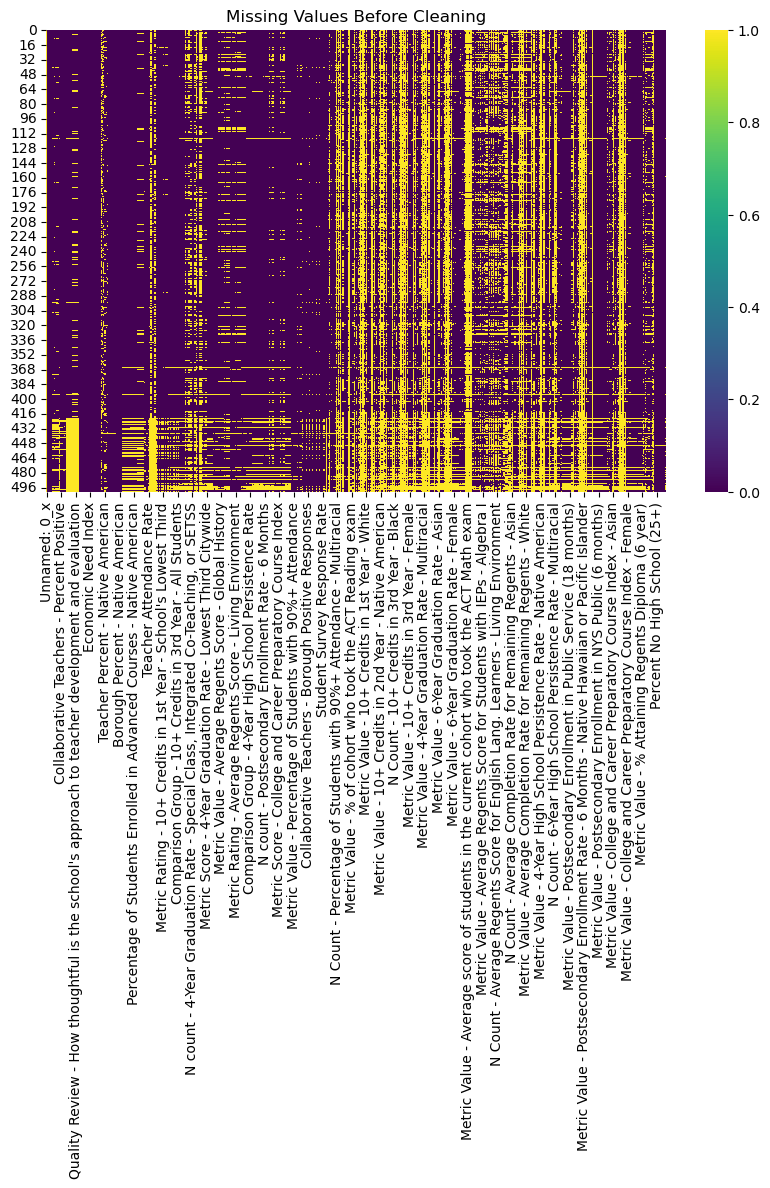

In [94]:
# check pre cleaning missingness
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis")
plt.title("Missing Values Before Cleaning")
plt.show()

In [95]:
#columns to remove by string
#Unnamed: remove NA columns
#N count / metric rating / metric score / comparison group: we just need metric value % columns, these give the same info
#positive responses / percent positive: remove borough and city positive response columns - we just need element score for these metrics
#quality review: these metrics are included in the Element score metrics
string_check = "Unnamed|N count|metric rating|metric score|comparison group|positive responses|percent positive|Quality Review"

#we dont need granularity of scores by specific courses
specific_courses = "Chemistry|Earth Science|Algebra|US History|Geometry|Global History|Living Environment|Credits"

#exclude granularity of demographics
demographics = 'Asian|White|Native|Black|Hispanic|Male|Female|English Lang|ELL|IEPs|NYSAA'

df = df.loc[:, ~df.columns.str.contains(string_check, regex=True, case=False)]
df = df.loc[:, ~df.columns.str.contains(specific_courses, regex=True, case=False)]
#df = df.loc[:, ~df.columns.str.contains(demographics, regex=True, case=False)]

df= df.loc[:, ~(df.columns.str.contains(demographics, regex=True, case=False) & ~(df.columns.str.contains('percent ', regex=True, case=False)))]

In [96]:
#drop School Type (they are all High Schools) and columns with survey response questions, we have score columns for this
df = df.drop(columns=['School Type','Rigorous Instruction Rating','Collaborative Teachers Rating','Supportive Environment Rating','Effective School Leadership Rating','Strong Family-Community Ties Rating','Trust Rating','Student Achievement Rating'], axis=1)


### Feature Engineering

In [97]:
#average rates that are 4 and 6 years then drop
df['Graduation Rate'] = df[['Metric Value - 6-Year Graduation Rate - All Students', 'Metric Value - 4-Year Graduation Rate - All Students']].mean(axis=1)
df['% Attaining Regents Diploma'] = df[['Metric Value - % Attaining Regents Diploma (4 year)', 'Metric Value - % Attaining Regents Diploma (6 year)']].mean(axis=1)
df['High School Persistence Rate'] = df[['Metric Value - 6-Year High School Persistence Rate', 'Metric Value - 4-Year High School Persistence Rate']].mean(axis=1)
df = df.drop(columns=['Metric Value - 6-Year Graduation Rate - All Students',
                    'Metric Value - 4-Year Graduation Rate - All Students',
                    'Metric Value - % Attaining Regents Diploma (4 year)',
                    'Metric Value - % Attaining Regents Diploma (6 year)',
                    'Metric Value - 4-Year High School Persistence Rate',
                    'Metric Value - 6-Year High School Persistence Rate'])

In [98]:
#Combine student demographic percentages - group black and hispanic since its the majority
df['Student Percent - Black and Hispanic'] = (df['Student Percent - Black'] + df['Student Percent - Hispanic'])
df['Student Percent - Other'] = df['Student Percent - Native American'] + df['Student Percent - Native Hawaiian or Pacific Islander'] + df['Student Percent - Asian'] + df['Student Percent - White']
df = df.drop(['Student Percent - White','Student Percent - Native American', 'Student Percent - Native Hawaiian or Pacific Islander','Student Percent - Asian', 'Student Percent - Black', 'Student Percent - Hispanic'], axis=1)

#Combine teacher demographic percentages - 2 groups: Teacher White and Teacher Other
df['Teacher - Other'] = df['Teacher Percent - Native American'] + df['Teacher Percent - Native Hawaiian or Pacific Islander'] + df['Teacher Percent - Asian'] + df['Teacher Percent - Hispanic'] + df['Teacher Percent - Black']
df = df.drop(['Teacher Percent - Native American', 'Teacher Percent - Native Hawaiian or Pacific Islander','Teacher Percent - Asian', 'Teacher Percent - Black', 'Teacher Percent - Hispanic'], axis=1)

#Remove nearby student percentages
#df['Nearby Student Percent - Black and Hispanic'] = (df['Nearby Student Percent - Black'] + df['Nearby Student Percent - Hispanic'])
#df['Nearby Student Percent - Other'] = df['Nearby Student Percent - Native American'] + df['Nearby Student Percent - Native Hawaiian or Pacific Islander'] + df['Nearby Student Percent - Asian'] + df['Nearby Student Percent - White']
df = df.drop(['Nearby Student Percent - White','Nearby Student Percent - Native American', 'Nearby Student Percent - Native Hawaiian or Pacific Islander','Nearby Student Percent - Asian', 'Nearby Student Percent - Black', 'Nearby Student Percent - Hispanic'], axis=1)

#Remove Borough Percentages
#df['Borough Percent - Black and Hispanic'] = (df['Borough Percent - Black'] + df['Borough Percent - Hispanic'])
#df['Borough Percent - Other'] = df['Borough Percent - Native American'] + df['Borough Percent - Native Hawaiian or Pacific Islander'] + df['Borough Percent - Asian'] + df['Borough Percent - White']
df = df.drop(['Borough Percent - White','Borough Percent - Native American', 'Borough Percent - Native Hawaiian or Pacific Islander','Borough Percent - Asian', 'Borough Percent - Black', 'Borough Percent - Hispanic'], axis=1)

In [99]:
#only keep general postsecondary enrollment and graduation columns
df = df.loc[:, ~((df.columns.str.contains("postsecondary enrollment", case=False)) & ~(df.columns == "Metric Value - Postsecondary Enrollment Rate"))]
df= df.loc[:, ~(df.columns.str.contains('graduated|graduation', regex=True, case=False) & ~(df.columns == "Graduation Rate"))]

In [100]:
#extract District and Borough from DBN column - DBN: (##(District)X(Borough)###(School ID))
df = df.copy()
df['District'] = df['DBN'].str[0:2]
df['Borough'] = df['DBN'].str[2:3]

#map borough name to value
borough_map = {'M': 'Manhattan', 'K': 'Brooklyn', 'X': 'Bronx', 'Q':'Queens', 'R':'Staten Island'}
df['Borough'] = df['Borough'].map(borough_map) 

In [101]:
#combine ACT metrics
df['Percent who took ACT'] = df[['Metric Value - % of cohort who took the ACT English exam','Metric Value - % of cohort who took the ACT Reading exam']].mean(axis=1)
df['Percent with 20+ ACT'] = df[['Metric Value - % of students in the current cohort who took the ACT English exam who scored 20+','Metric Value - % of students in the current cohort who took the ACT Math exam who scored 21+']].mean(axis=1)
df = df.drop(['Metric Value - % of cohort who took the ACT English exam','Metric Value - % of cohort who took the ACT Reading exam','Metric Value - % of students in the current cohort who took the ACT English exam who scored 20+','Metric Value - % of students in the current cohort who took the ACT Math exam who scored 21+'], axis=1)

#SAT metrics
df['Percent College Ready based on SAT Math'] = df['Metric Value - % of students in the current cohort who took the SAT Math exam who passed the college ready threshold']
df.drop(['Metric Value - % of students in the current cohort who took the SAT Math exam who passed the college ready threshold','Metric Value - % of students in the current cohort who took the SAT Reading and Writing exam and scored 480+'], axis=1, inplace=True )

#Regents metrics - drop repetitive metrics
df = df.drop(columns=['Metric Value - % of students who took the English Regents exam and are college ready (scored 70+)','Metric Value - % of students who took the English Regents exam in the current year who scored 65+'])

In [102]:
#combine 8th grade proficiency metrics
df['Average Grade 8 Proficiency'] = df[['Average Grade 8 English Proficiency', 'Average Grade 8 Math Proficiency']].mean(axis=1)
df.drop(columns =['Average Grade 8 English Proficiency','Average Grade 8 Math Proficiency'],inplace=True)

#drop lowest third citywide metrics since it is based on average grade 8 proficiency  
df = df.loc[:, ~(df.columns.str.contains('Lowest Third'))]

In [103]:
#drop students recommended for Individualized Education Programs (IEPs)
df.drop(['Percentage of students recommended for general ed settings with Special Ed Teacher Support Services (SETSS)','Percentage of students recommended for Integrated Co-Teaching (ICT) services','Percentage of students recommended for Special Class (SC) services'], axis=1, inplace=True)


In [104]:
#drop columns that give same info as targets: graduation rate and chronic absenteeism
df.drop(columns=['High School Persistence Rate','% Attaining Regents Diploma','Metric Value - Percentage of Students with 90%+ Attendance','Average Student Attendance'], inplace=True)

In [105]:
#drop columns that are captured in the College and Career Preparatory Course Index (CCPCI)
#info taken from School Quality Reports Educator Guide
df = df.drop(columns=['Metric Value - % Scoring 3+ on any AP Exam',
       'Metric Value - % Passing a NYCPS-certified CPCC Course',
       'Metric Value - % Passing an Industry-Recognized Technical Assessment',
       'Metric Value - % Scoring 4+ on any IB Exam',
       "Metric Value - % Earning a Grade of 'C' or Higher for College Credit",
       'Metric Value - % Scoring 65+ on Alg2, Chem, or Phys Regents Exam',
       'Metric Value - % Earning a Diploma with an Arts Endorsement',
       'Metric Value - % Earning a Diploma with a CTE Endorsement'], axis=1)

### Handle Data Types

**Data Type Correction and Formatting**:

Before processing, the data types summary shows:
| float64 | 346 |
| object | 317 |

After processing and removing rows, the summary shows:
| float64 | 64 |
| object | 4 |

The remaining object columns are 'DBN', 'School Name', 'District', and 'Borough'. We will keep these for EDA purposes. 

I used sklearn's ordinal encoder to encode the categorical values of quality review columns. The value provided were : 'Developing' 'Well Developed', 'Proficient'. I encoded them in this order and handled unkown values as -1.

Converting all columns to numeric is essential for EDA to create plots and for modeling as regression will only take numeric values.

In [106]:
#convert rate % to float
df['Student Survey Response Rate'] = pd.to_numeric(df['Student Survey Response Rate'].str[:-1])
df['Teacher Survey Response Rate'] = pd.to_numeric(df['Teacher Survey Response Rate'].str[:-1])
df['Parent Survey Response Rate'] = pd.to_numeric(df['Parent Survey Response Rate'].str[:-1])

#convert all metric value columns to numeric
df.loc[:, df.columns.str.contains('Metric Value')] = df.loc[:, df.columns.str.contains('Metric Value')].apply(pd.to_numeric, errors='coerce')

### Handle Missingness

**Managing Missing Data**:
According to the Educator Guide, "metrics with fewer than the minimum number of students are not reported and do not
contribute to the school’s ratings because of confidentiality considerations and the unreliability of measurements based on small numbers" [@NYCPublicSchoolsInfoHub_2024]. These are shown in the data as values of 'N<15' and 'N<5'. We cannot impute 0 for these values since that would fasely discredit the school. Instead, I changed these values to NA and did not include them when processing. 

Further, to handle large amounts of missing data, I removed columns where greater than 50% of the data is missing. This helped to reduce size of the dataframe by removing 100+ columns which would not have been helpful to our analysis since it was missing too much. I then imputed data that was missing less than 10% of the data. I imputed based on the skew of the distribution, if the skew was greater than the absolute value of 0.5, I used median to impute, and if the skew appeared to be a normal position, I used the mean to impute. I then removed the remaining three columns with missingness that did not meet the threshold to obtain a complete dataset.

In [107]:
len(df.columns)

72

In [108]:
def handle_missingness(df, threshold=0.1):
    """Function for imputing data using skew when missingness < 10% and removing columns with missingness > 50% """
    for col in df.columns:
        missingness = df[col].isna().sum() / len(df)
        if missingness < 0.1:
            if df[col].dtype == 'float64':
                col_skew = skew(df[col].dropna()) 
                if abs(col_skew) > 0.5:
                    df[col] = df[col].fillna(df[col].median())
                else: 
                    df[col] = df[col].fillna(df[col].mean())
            elif df[col].dtype == 'object':
                df[col] = df[col].fillna(df[col].mode()[0]) 
        elif missingness > 0.5:
            df.drop([col], axis=1, inplace=True)
    return df

In [109]:
df = handle_missingness(df)

In [110]:
#check null count of each column
df.isnull().sum().sort_values(ascending=False).head(20)

Metric Value - Average score of students in the current cohort who took the SAT Math exam                   76
Metric Value - Average score of students in the current cohort who took the SAT Reading and Writing exam    76
Student Achievement - Section Score                                                                         72
Metric Value - Average Completion Rate for Remaining Regents                                                52
Percent Male                                                                                                 0
Percent Neither Female nor Male                                                                              0
Percent English Language Learners                                                                            0
Percent Students with IEPs                                                                                   0
Economic Need Index                                                                                          0
P

In [111]:
#drop remaining columns with missingness
df = df.drop(columns=['Metric Value - Average score of students in the current cohort who took the SAT Reading and Writing exam','Metric Value - Average score of students in the current cohort who took the SAT Math exam','Student Achievement - Section Score','Metric Value - Average Completion Rate for Remaining Regents'], axis=1)


In [112]:
#Post cleaning data check

df.dtypes.value_counts()

float64    52
object      4
Name: count, dtype: int64

In [113]:
#check remaining objects - keep these for EDA
df.select_dtypes(include=['object']).columns

Index(['DBN', 'School Name', 'District', 'Borough'], dtype='object')

In [114]:
#save processed df to csv
df.to_csv('../../data/processed-data/processed_df.csv', index=None)

In [115]:
# post cleaning df.head check
df.head()

,DBN,School Name,Enrollment,Percent Female,Percent Male,Percent Neither Female nor Male,Percent English Language Learners,Percent Students with IEPs,Economic Need Index,Percent Overage / Undercredited,...,dropout_rate,Graduation Rate,Student Percent - Black and Hispanic,Student Percent - Other,District,Borough,Percent who took ACT,Percent with 20+ ACT,Percent College Ready based on SAT Math,Average Grade 8 Proficiency
0,01M292,orchard collegiate academy,269.0,0.468,0.532,0.0,0.063,0.253,0.866,0.041,...,3.3,0.9390,0.766,0.227,01,Manhattan,0.000,0.0000,0.136,2.715
1,01M448,university neighborhood high school,485.0,0.487,0.513,0.0,0.118,0.210,0.814,0.029,...,2.9,0.9840,0.625,0.371,01,Manhattan,0.000,0.0000,0.225,3.050
2,01M450,east side community school,389.0,0.458,0.542,0.0,0.013,0.290,0.638,0.003,...,0.0,0.9765,0.684,0.283,01,Manhattan,0.022,0.0110,0.370,3.010
3,01M539,"new explorations into science, technology and ...",620.0,0.508,0.492,0.0,0.005,0.185,0.429,0.005,...,0.7,0.9935,0.249,0.705,01,Manhattan,0.083,0.0780,0.834,3.755
4,01M696,bard high school early college,565.0,0.577,0.423,0.0,0.005,0.147,0.482,0.004,...,0.0,0.9870,0.391,0.570,01,Manhattan,0.054,0.0445,0.762,3.840


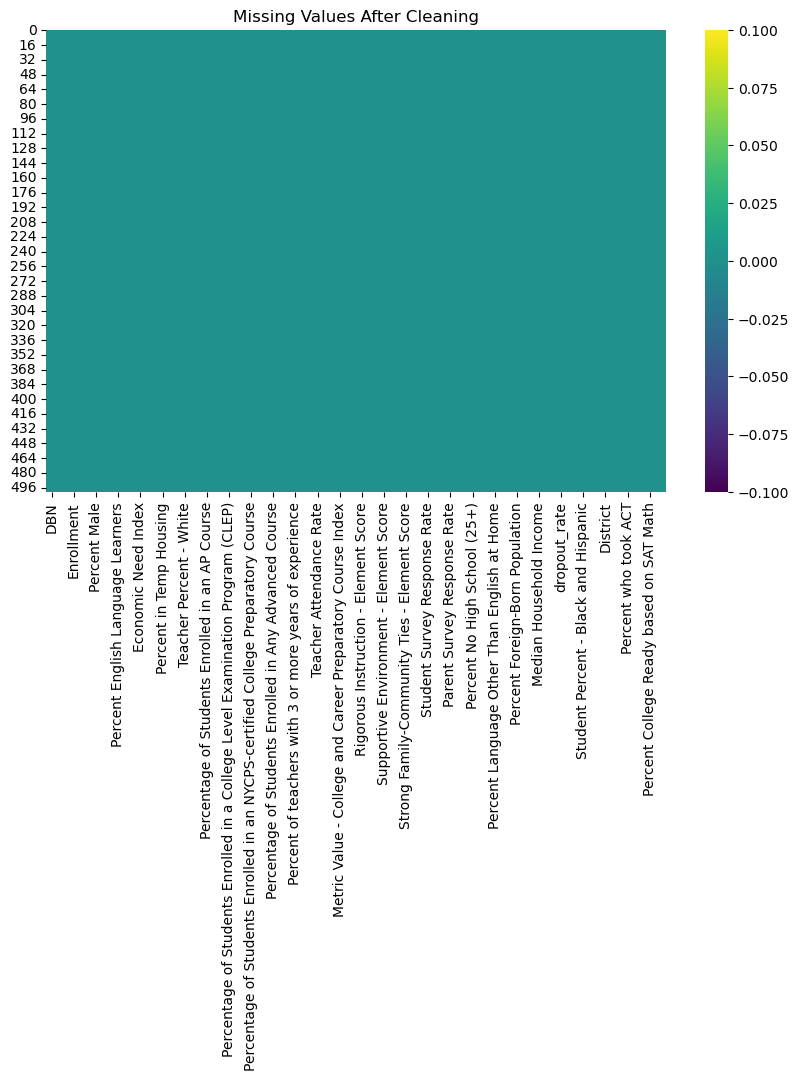

In [116]:
# post cleaning missingness check
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis")
plt.title("Missing Values After Cleaning")
plt.show()

### Conclusion
I chose to work with this particular subset of the data becasue it retains the the information of the columns I am interested in exploring. I chose to drop columns that were too granular such as specific Regents subjects. In addition, some metric columns contained the same info as the 'Metric Value' columns that I kept, so I was able to get rid of N count, metric rating, metric score, comparison group, and positive response columns.